# Preparations

### Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 8]
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

from portfolio_optimization import return_portfolios, optimal_portfolio

import datetime
import yfinance as yf

### Create time boundaries

In [5]:
end_date = datetime.datetime.now()
start_date = datetime.datetime.now() - datetime.timedelta(days=5*365)

### Init portfolio data

In [7]:
portfolio = ['AAPL', 'ABBV', 'BAC', 'BTI', 'C', 'CMCSA', 'FDX',  'GPS', 'HPQ', 'INTC', 'PFE', 'T', 'V']
current_weights = [0.1269, 0.1082, 0.0473, 0.0762, 0.0441, 0.0627, 0.1069, 0.1006, 0.0716, 0.0401, 0.0588, 0.0689, 0.0876]
portfolio_len = len(portfolio)

# Calculate efficient frontier

### Load the stock data quarterly

In [10]:
stock_data = yf.download(portfolio, start_date, end_date, interval='3mo')
stock_data = stock_data['Close']
stock_data = stock_data.reset_index()

[*********************100%***********************]  13 of 13 completed


### Calculate metrics

In [12]:
# Find the quarterly return for each period
selected = list(stock_data.columns[1:])
returns_quarterly = stock_data[selected].pct_change()
# Find the expected returns 
expected_returns = returns_quarterly.mean()
# Find the covariance 
cov_quarterly = returns_quarterly.cov()
# Find a set of random portfolios
random_portfolios = return_portfolios(expected_returns, cov_quarterly)

### Calculate efficient frontier

In [14]:
min_stock_fraction = 1/(portfolio_len*2)
max_stock_fraction = 2/portfolio_len
ef_portfolio_num = 100

max_return_weights, effective_frontier_returns, effective_frontier_risks, effective_frontier_weights = optimal_portfolio(returns_quarterly[1:], ef_portfolio_num, min_stock_fraction, max_stock_fraction)

# Calculate portfolios

### Max return portfolio parameters

In [17]:
mr_return = np.dot(max_return_weights[:,0], expected_returns)
mr_volatility = np.sqrt(np.dot(np.transpose(max_return_weights[:,0]), np.dot(cov_quarterly, max_return_weights[:,0])))
print(f'Max return portfolio return: {mr_return}')
print(f'Max return portfolio volatility: {mr_volatility}')

Max return portfolio return: 0.04514580028037915
Max return portfolio volatility: 0.13883784624575504


### Current portfolio parameters

In [19]:
current_return = np.dot(current_weights, expected_returns)
current_volatility = np.sqrt(np.dot(np.transpose(current_weights), np.dot(cov_quarterly, current_weights)))
print(f'Current portfolio return: {current_return}')
print(f'Current portfolio volatility: {current_volatility}')

Current portfolio return: 0.03438071813265896
Current portfolio volatility: 0.12028942684762843


### Equally-weighted portfolio parameters

In [21]:
equally_weights = np.ones((portfolio_len, 1)) * (1/portfolio_len)
equally_return = np.dot(equally_weights[:,0], expected_returns)
equally_volatility = np.sqrt(np.dot(equally_weights[:,0].T, np.dot(cov_quarterly, equally_weights[:,0])))
print(f'Equally-weighted portfolio return: {equally_return}')
print(f'Equally-weighted portfolio volatility: {equally_volatility}')

Equally-weighted portfolio return: 0.02490696990325486
Equally-weighted portfolio volatility: 0.11602244388563368


### Calculate effective portfolio with the closest return to current portfolio

In [23]:
ef_returns = np.array(effective_frontier_returns)
ef_returns_diff = abs(ef_returns - current_return)

equal_return_index = np.where(ef_returns_diff == min(ef_returns_diff))[0][0]
equal_return_weights = np.asarray(effective_frontier_weights[equal_return_index])

In [24]:
equal_return_return = np.dot(equal_return_weights[:,0], expected_returns)
equal_return_volatility = np.sqrt(np.dot(np.transpose(equal_return_weights[:,0]), np.dot(cov_quarterly, equal_return_weights[:,0])))
print(f'Equal return portfolio return: {equal_return_return}')
print(f'Equal return portfolio volatility: {equal_return_volatility}')

Equal return portfolio return: 0.03506111418085846
Equal return portfolio volatility: 0.1063068848891136


### Calculate effective portfolio with the closest risk to current portfolio

In [26]:
ef_risks = np.array(effective_frontier_risks)
ef_risks_diff = abs(ef_risks - current_volatility)

equal_risk_index = np.where(ef_risks_diff == min(ef_risks_diff))[0][0]
equal_risk_weights = np.asarray(effective_frontier_weights[equal_risk_index])

In [27]:
equal_risk_return = np.dot(equal_risk_weights[:,0], expected_returns)
equal_risk_volatility = np.sqrt(np.dot(np.transpose(equal_risk_weights[:,0]), np.dot(cov_quarterly, equal_risk_weights[:,0])))
print(f'Equal risk portfolio return: {equal_risk_return}')
print(f'Equal risk portfolio volatility: {equal_risk_volatility}')

Equal risk portfolio return: 0.04057601475241822
Equal risk portfolio volatility: 0.11982641546039124


# Results

### Draw results

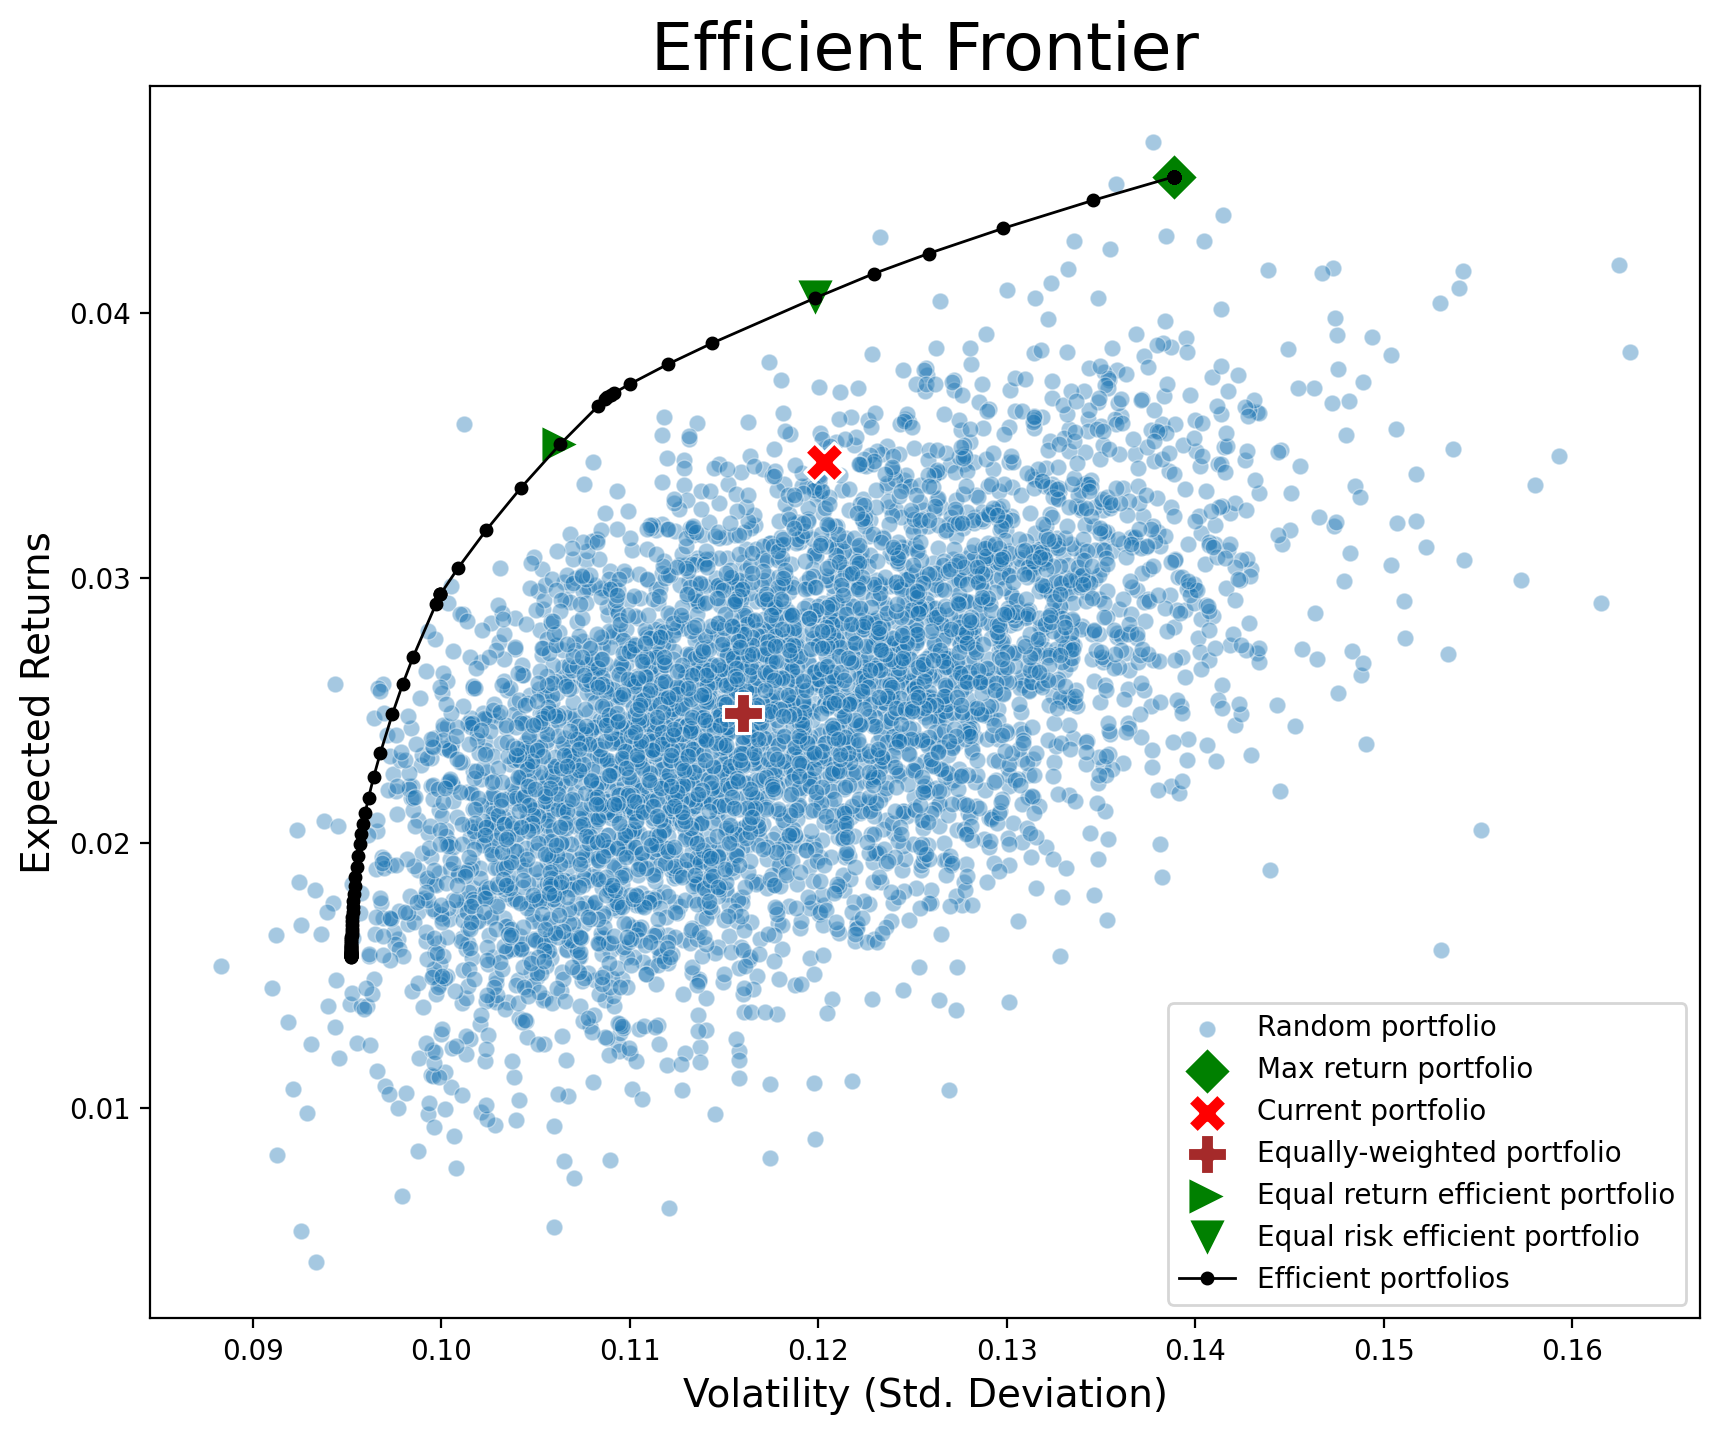

In [30]:
sns.scatterplot(data=random_portfolios, x='Volatility', y='Returns', alpha=0.4, label='Random portfolio')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)

sns.scatterplot(x=[mr_volatility], y=[mr_return], marker='D', color='green', s=150, label='Max return portfolio')
sns.scatterplot(x=[current_volatility], y=[current_return], marker='X', color='red', s=200, label='Current portfolio')
sns.scatterplot(x=[equally_volatility], y=[equally_return], marker='P', color='brown', s=200, label='Equally-weighted portfolio')
sns.scatterplot(x=[equal_return_volatility], y=[equal_return_return], marker='>', color='green', s=200, label='Equal return efficient portfolio')
sns.scatterplot(x=[equal_risk_volatility], y=[equal_risk_return], marker='v', color='green', s=200, label='Equal risk efficient portfolio')

# Plot the set of portfolios on the EF
plt.plot(effective_frontier_risks, effective_frontier_returns, 'k-o', linewidth=1, ms=4, label='Efficient portfolios')
plt.legend()

plt.show()

### Print portfolios weights

In [32]:
max_return_portfolio = pd.DataFrame(max_return_weights[:,0], index=portfolio, columns=['Max return weights'])
equal_return_portfolio = pd.DataFrame(equal_return_weights[:,0], index=portfolio, columns=['Equal return weights'])
equal_risk_portfolio = pd.DataFrame(equal_risk_weights[:,0], index=portfolio, columns=['Equal risk weights'])

portfolios = pd.concat([max_return_portfolio, equal_return_portfolio, equal_risk_portfolio], axis=1)

portfolios

,Max return weights,Equal return weights,Equal risk weights
AAPL,0.153846,0.153846,0.153846
ABBV,0.153846,0.153846,0.153846
BAC,0.038462,0.038462,0.038462
BTI,0.038462,0.072862,0.038462
C,0.038462,0.038462,0.038462
CMCSA,0.038462,0.038462,0.038462
FDX,0.153846,0.065446,0.153845
GPS,0.153846,0.038462,0.062580
HPQ,0.076923,0.130843,0.153846
INTC,0.038462,0.038462,0.038462


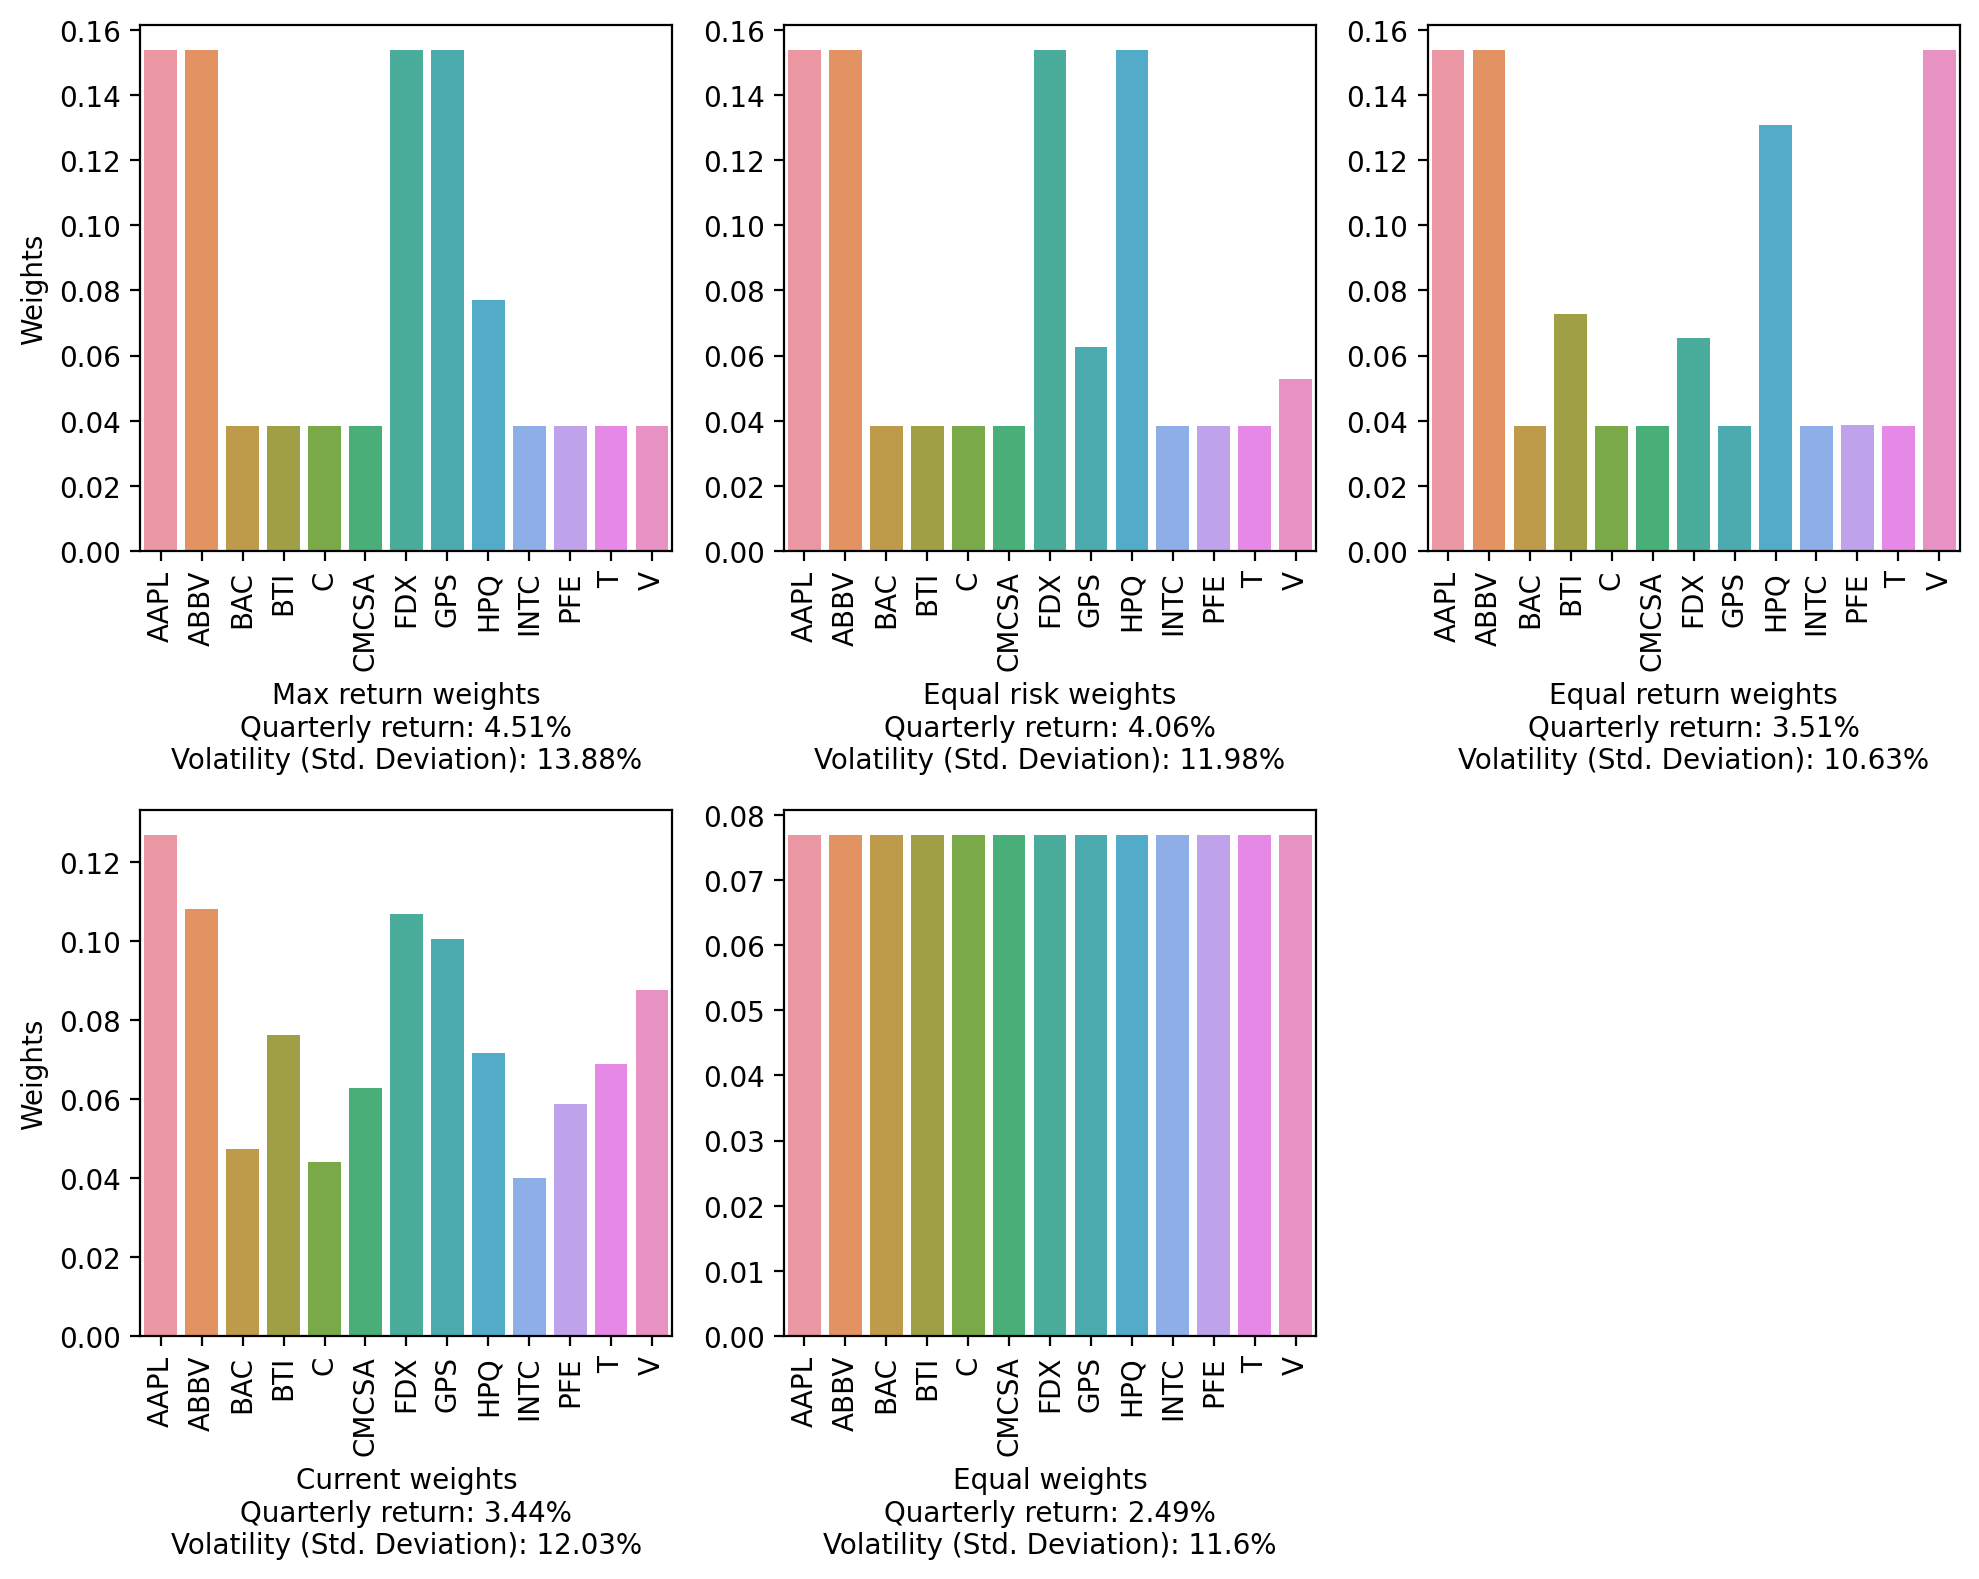

In [33]:
ax1 = plt.subplot(2,3,1)
sns.barplot(x=portfolios.index, y=portfolios['Max return weights'])
plt.ylabel("Weights");
plt.xlabel(f"Max return weights\nQuarterly return: {round(mr_return*100,2)}%\nVolatility (Std. Deviation): {round(mr_volatility*100,2)}%");
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.tight_layout()

ax2 = plt.subplot(2,3,2)
sns.barplot(x=portfolios.index, y=portfolios['Equal risk weights'])
plt.ylabel("");
plt.xlabel(f"Equal risk weights\nQuarterly return: {round(equal_risk_return*100,2)}%\nVolatility (Std. Deviation): {round(equal_risk_volatility*100,2)}%");
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
plt.tight_layout()

ax3 = plt.subplot(2,3,3)
sns.barplot(x=portfolios.index, y=portfolios['Equal return weights'])
plt.ylabel("");
plt.xlabel(f"Equal return weights\nQuarterly return: {round(equal_return_return*100,2)}%\nVolatility (Std. Deviation): {round(equal_return_volatility*100,2)}%");
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
plt.tight_layout()

ax4 = plt.subplot(2,3,4)
sns.barplot(x=portfolio, y=current_weights)
plt.ylabel("Weights");
plt.xlabel(f"Current weights\nQuarterly return: {round(current_return*100,2)}%\nVolatility (Std. Deviation): {round(current_volatility*100,2)}%");
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)
plt.tight_layout()

ax5 = plt.subplot(2,3,5)
sns.barplot(x=portfolio, y=equally_weights[:,0])
plt.ylabel("");
plt.xlabel(f"Equal weights\nQuarterly return: {round(equally_return*100,2)}%\nVolatility (Std. Deviation): {round(equally_volatility*100,2)}%");
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=90)
plt.tight_layout()

plt.show()